# Ames, Iowa Housing Predictions

## Table of contents:
- [EDA](#EDA)
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [More EDA](#More-EDA)
- [Modeling](#Modeling)
- [Evaluation](#Evaluation)

# EDA

## Imports and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')

# Set ID to be the index
df.set_index('Id', inplace =True)
test_df.set_index('Id', inplace =True)

## Basic EDA

The first thing we need to do is get a sense of what our data looks like to know how to proceed with cleaning and prediction modeling. 

In [3]:
# Check the first 5 rows of training data
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
# Check the first 5 rows of test data
test_df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [5]:
# Check number of rows and columns in both dataframes
print("Train data dataframe shape:", df.shape[0], 'by', df.shape[1])
print("Test data dataframe shape:", test_df.shape[0], 'by', test_df.shape[1])

Train data dataframe shape: 2051 by 80
Test data dataframe shape: 879 by 79


In [6]:
# Check column datatypes and number of values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2051 non-null object
Roof Matl          2

We can see we don't have the same number of values in each columns. Depending on each variable and looking at the data dictionary we can decide to deal with missing values in different ways, either discarding the variables completely or filling in the missing values if the data dictionary provides additional information on why some values are missing.
The first thing to do is to check how many NaNs we have per column, then we clean the data accordingly.

In [7]:
# Check the number of null values
df.isnull().sum().sort_values().tail(10)

Garage Yr Blt     114
Garage Cond       114
Garage Finish     114
Garage Qual       114
Lot Frontage      330
Fireplace Qu     1000
Fence            1651
Alley            1911
Misc Feature     1986
Pool QC          2042
dtype: int64

## Looking for Outliers

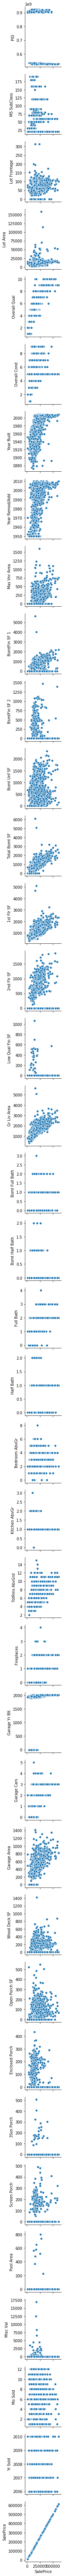

In [12]:
# Plotting scatter plots to see if there are any outliers
sns.pairplot(df, y_vars=list(df.describe().columns), x_vars=['SalePrice'])
sns.PairGrid()

# Data Cleaning

## Handling missing values

In [8]:
#So as not to lose data, fill all NAs with meaningful values 
#(either a 0 or a string saying the feature is missing, depending on the feature)
#check data dictionary for the meaning of NAs in each column

df['Fireplace Qu'].fillna(0, inplace=True)
df['Garage Type'].fillna('No Garage', inplace=True)
df['Garage Finish'].fillna('No Garage', inplace=True)
df['Garage Cond'].fillna(0, inplace=True)
df['Lot Frontage'].fillna(0, inplace=True)
df['Garage Qual'].fillna(0, inplace=True)
df['Garage Yr Blt'].fillna(0, inplace=True)
df['Bsmt Qual'].fillna(0, inplace=True)
df['Bsmt Cond'].fillna(0, inplace=True)
df['Bsmt Exposure'].fillna(0, inplace=True)
df['BsmtFin Type 2'].fillna('No Basement', inplace=True)
df['BsmtFin Type 1'].fillna('No Basement', inplace=True)
df['Fence'].fillna(0, inplace=True)
df['Pool QC'].fillna(0, inplace=True)
df['Misc Feature'].fillna('No Misc Feature', inplace=True)
df['Alley'].fillna('No Alley', inplace=True)

test_df['Garage Type'].fillna('No Garage', inplace=True)
test_df['Fireplace Qu'].fillna(0, inplace=True)
test_df['Garage Finish'].fillna('No Garage', inplace=True)
test_df['Garage Cond'].fillna(0, inplace=True)
test_df['Lot Frontage'].fillna(0, inplace=True)
test_df['Garage Qual'].fillna(0, inplace=True)
test_df['Garage Yr Blt'].fillna(0, inplace=True)
test_df['Bsmt Qual'].fillna(0, inplace=True)
test_df['Bsmt Cond'].fillna(0, inplace=True)
test_df['Bsmt Exposure'].fillna(0, inplace=True)
test_df['BsmtFin Type 2'].fillna('No Basement', inplace=True)
test_df['BsmtFin Type 1'].fillna('No Basement', inplace=True)
test_df['Mas Vnr Area'].fillna(0, inplace=True)
test_df['Fence'].fillna(0, inplace=True)
test_df['Electrical'].fillna(0, inplace=True)
test_df['Pool QC'].fillna(0, inplace=True)
test_df['Misc Feature'].fillna('No Misc Feature', inplace=True)
test_df['Alley'].fillna('No Alley', inplace=True)

In [9]:
# Check the number of null values remaining
df.isnull().sum().sort_values().tail()

BsmtFin SF 2       1
Bsmt Half Bath     2
Bsmt Full Bath     2
Mas Vnr Area      22
Mas Vnr Type      22
dtype: int64

In [10]:
# We can drop the remaining rows, where we don't know what the Nan values mean
df.dropna(inplace=True)

## Handling Outliers

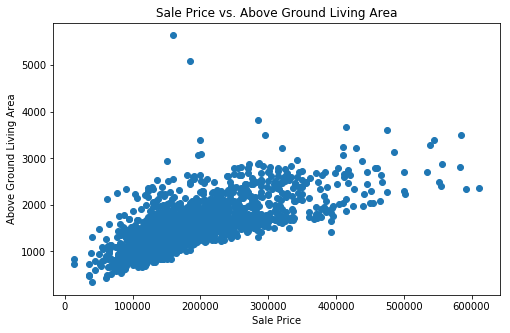

In [9]:
# finding outliers
plt.figure(figsize=(8,5))
plt.scatter(df['SalePrice'], df['Gr Liv Area'])
plt.title('Sale Price vs. Above Ground Living Area')
plt.xlabel('Sale Price')
plt.ylabel('Above Ground Living Area');

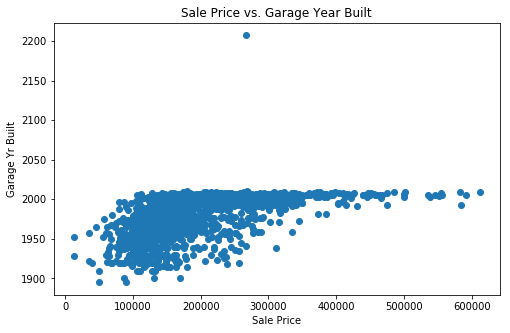

In [10]:
# Abnormal value here
plt.figure(figsize=(8,5))
plt.scatter(df['SalePrice'], df['Garage Yr Blt'])
plt.title('Sale Price vs. Garage Year Built')
plt.xlabel('Sale Price')
plt.ylabel('Garage Yr Built');

Two outliers clear in all graphs where we plot sq feet vs price. One listing shows a garage built in 2200, so we drop those rows

In [11]:
# Finding the ID of the listing that has a garage year built in 2200 
mask = df['Garage Yr Blt'] > 2200
df[mask]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2261,916384070,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,9,2007,New,267300


In [12]:
# obvious typo! the house was built in 2007, so we change it to 2007
df.loc[df['Garage Yr Blt'] == 2207]['Garage Yr Blt'] = 2007

/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
# Finding the IDs of the listings that have a total basement sq feet of more than 4000 (clear outliers) 
mask = df['Total Bsmt SF'] > 4000
df[mask]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,0,480,Gd,NaN,NaN,0,1,2008,New,160000
2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [14]:
# drop the outliers, we dont want to fit the model to them
df.drop(labels=[2181, 1499], inplace=True)

In [15]:
# PID is an integer that has no meaning
df = df.drop(['PID'], axis=1)
test_df = test_df.drop(['PID'], axis=1)

# Feature Engineering

## Year and Month

In [18]:
# Year and months sold here take values of integers which implies one month is greater than the other.. 
# which is not the case, so we create dummy variables for both the year and month sold.

yearsold_dummies = pd.get_dummies(df['Yr Sold'], prefix='yearsold', drop_first=True)
test_yearsold_dummies = pd.get_dummies(test_df['Yr Sold'], prefix='yearsold', drop_first=True)

monthsold_dummies = pd.get_dummies(df['Mo Sold'], prefix='monthsold', drop_first=True)
test_monthsold_dummies = pd.get_dummies(test_df['Mo Sold'], prefix='monthsold', drop_first=True)

In [19]:
# now we drop the original columns
df = df.drop(['Yr Sold', 'Mo Sold'], axis=1)
test_df = test_df.drop(['Yr Sold', 'Mo Sold'], axis=1)

### Dealing with categorical columns: Dummies

In [20]:
# Turn all nominal columns into dummies

landcontour_dummies = pd.get_dummies(df['Land Contour'], prefix='landcontour', drop_first=True)
test_landcontour_dummies = pd.get_dummies(test_df['Land Contour'], prefix='landcontour', drop_first=True)

street_dummies = pd.get_dummies(df['Street'], prefix='street', drop_first=True)
test_street_dummies = pd.get_dummies(test_df['Street'], prefix='street', drop_first=True)

utilities_dummies = pd.get_dummies(df['Utilities'], prefix='utilities', drop_first=True)
test_utilities_dummies = pd.get_dummies(test_df['Utilities'], prefix='utilities', drop_first=True)

df['lotconfig_dummies'] = df['Lot Config'].map(lambda cell: 1 if ((cell == 'FR3') | (cell == 'CulDSac')) else 0)
test_df['lotconfig_dummies'] = test_df['Lot Config'].map(lambda cell: 1 if ((cell == 'FR3') | (cell == 'CulDSac')) else 0)

neighborhood_dummies = pd.get_dummies(df['Neighborhood'], prefix='neighborhood', drop_first=True)
test_neighborhood_dummies = pd.get_dummies(test_df['Neighborhood'], prefix='neighborhood', drop_first=True)

cond1_dummies = pd.get_dummies(df['Condition 1'], prefix='cond1', drop_first=True)
test_cond1_dummies = pd.get_dummies(test_df['Condition 1'], prefix='cond1', drop_first=True)

cond2_dummies = pd.get_dummies(df['Condition 2'], prefix='cond2', drop_first=True)
test_cond2_dummies = pd.get_dummies(test_df['Condition 2'], prefix='cond2', drop_first=True)

alley_dummies = pd.get_dummies(df['Alley'], prefix='alley', drop_first=True)
test_alley_dummies = pd.get_dummies(test_df['Alley'], prefix='alley', drop_first=True)

misc_dummies = pd.get_dummies(df['Misc Feature'], prefix='misc', drop_first=True)
test_misc_dummies = pd.get_dummies(test_df['Misc Feature'], prefix='misc', drop_first=True)

bldg_dummies = pd.get_dummies(df['Bldg Type'], prefix='bldgtype', drop_first=True)
test_bldg_dummies = pd.get_dummies(test_df['Bldg Type'], prefix='bldgtype', drop_first=True)

house_dummies = pd.get_dummies(df['House Style'], prefix='housestyle', drop_first=True)
test_house_dummies = pd.get_dummies(test_df['House Style'], prefix='housestyle', drop_first=True)

roof_dummies = pd.get_dummies(df['Roof Style'], prefix='roofstyle', drop_first=True)
test_roof_dummies = pd.get_dummies(test_df['Roof Style'], prefix='roofstyle', drop_first=True)

roofmatl_dummies = pd.get_dummies(df['Roof Matl'], prefix='roofmatl', drop_first=True)
test_roofmatl_dummies = pd.get_dummies(test_df['Roof Matl'], prefix='roofmatl', drop_first=True)

exterior1_dummies = pd.get_dummies(df['Exterior 1st'], prefix='exterior1', drop_first=True)
test_exterior1_dummies = pd.get_dummies(test_df['Exterior 1st'], prefix='exterior1', drop_first=True)

exterior2_dummies = pd.get_dummies(df['Exterior 2nd'], prefix='exterior2', drop_first=True)
test_exterior2_dummies = pd.get_dummies(test_df['Exterior 2nd'], prefix='exterior2', drop_first=True)

mssubclass_dummies = pd.get_dummies(df['MS SubClass'], prefix='mssubclass', drop_first=True)
test_mssubclass_dummies = pd.get_dummies(test_df['MS SubClass'], prefix='mssubclass', drop_first=True)

mszoning_dummies = pd.get_dummies(df['MS Zoning'], prefix='mszoning', drop_first=True)
test_mszoning_dummies = pd.get_dummies(test_df['MS Zoning'], prefix='mszoning', drop_first=True)

masvnrtype_dummies = pd.get_dummies(df['Mas Vnr Type'], prefix='masvnrtype', drop_first=True)
test_masvnrtype_dummies = pd.get_dummies(test_df['Mas Vnr Type'], prefix='masvnrtype', drop_first=True)

foundation_dummies = pd.get_dummies(df['Foundation'], prefix='foundation', drop_first=True)
test_foundation_dummies = pd.get_dummies(test_df['Foundation'], prefix='foundation', drop_first=True)

heating_dummies = pd.get_dummies(df['Heating'], prefix='heating', drop_first=True)
test_heating_dummies = pd.get_dummies(test_df['Heating'], prefix='heating', drop_first=True)

df['centralair_dummies'] = df['Central Air'].map(lambda centralair: 1 if centralair == 'Y' else 0)
test_df['centralair_dummies'] = test_df['Central Air'].map(lambda centralair: 1 if centralair == 'Y' else 0)

df['garagetype_dummies'] = df['Garage Type'].map(lambda cell: 1 if ((cell == 'BuiltIn') | (cell == 'Attchd')) else 0)
test_df['garagetype_dummies'] = test_df['Garage Type'].map(lambda cell: 1 if ((cell == 'BuiltIn') | (cell == 'Attchd')) else 0)

saletype_dummies = pd.get_dummies(df['Sale Type'], prefix='saletype', drop_first=True)
test_saletype_dummies = pd.get_dummies(test_df['Sale Type'], prefix='saletype', drop_first=True)

In [21]:
# MS SubClass is an int column but is a categorical value.
# Since we already turned it into a dummy we can drop the original column

df.drop(labels=['MS SubClass'], axis=1, inplace=True)
test_df.drop(labels=['MS SubClass'], axis=1, inplace=True)

### Dealing with quality and condition columns

In [22]:
def lotshape_rating_map(rating):
    lot_dict = {'IR3': 1, 'IR2': 2, 'IR1' : 3, 'Reg':4}
    return lot_dict[rating]

def landslope_rating_map(rating):
    slope_dict = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
    return slope_dict[rating]

def paved_rating_map(rating):
    paved_dict = {'N':1, 'P': 2, 'Y':3}
    return paved_dict[rating]

def garage_finish_rating(rating):
    garage_dict = {'No Garage':0, 'Unf':1, 'RFn': 2, 'Fin': 3}
    return garage_dict[rating]

def rating_map(rating):
    rating_dict = {0 : 0, 'Po' : 1,'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}
    return rating_dict[rating]

def exprating_map(rating):
    rating_dict = {0 : 0, 'No' : 1, 'Mn': 2, 'Av' : 3, 'Gd' : 4}
    return rating_dict[rating]

def bsmtfin_rating_map(rating):
    bsmt_dict = {'No Basement':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
    return bsmt_dict[rating]

def pool_rating_map(rating):
    pool_dict = {0: 0, 'TA' : 1, 'Fa': 2, 'Gd' : 3, 'Ex': 4}
    return pool_dict[rating]

def fence_rating_map(rating):
    fence_dict = {0:0, 'MnWw':1, 'GdWo':2, 'MnPrv': 3, 'GdPrv':4}
    return fence_dict[rating]

def electrical_rating_map(rating):
    electrical_dict = {0: 0, 'Mix': 1, 'FuseP': 2, 'FuseF': 3, 'FuseA' : 4, 'SBrkr': 5}
    return electrical_dict[rating]

def functional_rating_map(rating):
    functional_dict = {'Sal': 1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}
    return functional_dict[rating]

In [23]:
# map all rating columns to a corresponding numerical value

df['lotshape_rating'] = df['Lot Shape'].map(lotshape_rating_map)
test_df['lotshape_rating'] = test_df['Lot Shape'].map(lotshape_rating_map)

df['paved_rating'] = df['Paved Drive'].map(paved_rating_map)
test_df['paved_rating'] = test_df['Paved Drive'].map(paved_rating_map)

df['garagecond_rating'] = df['Garage Cond'].map(rating_map)
test_df['garagecond_rating'] = test_df['Garage Cond'].map(rating_map)

df['garagequal_rating'] = df['Garage Qual'].map(rating_map)
test_df['garagequal_rating'] = test_df['Garage Qual'].map(rating_map)

df['garagefinish_rating'] = df['Garage Finish'].map(garage_finish_rating)
test_df['garagefinish_rating'] = test_df['Garage Finish'].map(garage_finish_rating)

df['electrical_rating'] = df['Electrical'].map(electrical_rating_map)
test_df['electrical_rating'] = test_df['Electrical'].map(electrical_rating_map)

df['kitchenqual_rating'] = df['Kitchen Qual'].map(rating_map)
test_df['kitchenqual_rating'] = test_df['Kitchen Qual'].map(rating_map)

df['functional_rating'] = df['Functional'].map(functional_rating_map)
test_df['functional_rating'] = test_df['Functional'].map(functional_rating_map)

df['fireplacequ_rating'] = df['Fireplace Qu'].map(rating_map)
test_df['fireplacequ_rating'] = test_df['Fireplace Qu'].map(rating_map)

df['heatingqc_rating'] = df['Heating QC'].map(rating_map)
test_df['heatingqc_rating'] = test_df['Heating QC'].map(rating_map)

df['poolqc_rating'] = df['Pool QC'].map(pool_rating_map)
test_df['poolqc_rating'] = test_df['Pool QC'].map(pool_rating_map)

df['fence_rating'] = df['Fence'].map(fence_rating_map)
test_df['fence_rating'] = test_df['Fence'].map(fence_rating_map)

df['basementqual_rating'] = df['Bsmt Qual'].map(rating_map)
test_df['basementqual_rating'] = test_df['Bsmt Qual'].map(rating_map)

df['basementcond_rating'] = df['Bsmt Cond'].map(rating_map)
test_df['basementcond_rating'] = test_df['Bsmt Cond'].map(rating_map)

df['basementexp_rating'] = df['Bsmt Exposure'].map(exprating_map)
test_df['basementexp_rating'] = test_df['Bsmt Exposure'].map(exprating_map)

df['bsmtfint1_rating'] = df['BsmtFin Type 1'].map(bsmtfin_rating_map)
test_df['bsmtfint1_rating'] = test_df['BsmtFin Type 1'].map(bsmtfin_rating_map)

df['bsmtfint2_rating'] = df['BsmtFin Type 2'].map(bsmtfin_rating_map)
test_df['bsmtfint2_rating'] = test_df['BsmtFin Type 2'].map(bsmtfin_rating_map)

df['exterqual_rating'] = df['Exter Qual'].map(rating_map)
test_df['exterqual_rating'] = test_df['Exter Qual'].map(rating_map)

df['extercond_rating'] = df['Exter Cond'].map(rating_map)
test_df['extercond_rating'] = test_df['Exter Cond'].map(rating_map)

df['landslope_rating'] = df['Land Slope'].map(landslope_rating_map)
test_df['landslope_rating'] = test_df['Land Slope'].map(landslope_rating_map)

### Add interaction columns

In [24]:
df['fireplace_interaction'] = df['Fireplaces'] * df['fireplacequ_rating']
test_df['fireplace_interaction'] = test_df['Fireplaces'] * test_df['fireplacequ_rating']

df['yearbuilt_times_yearremod'] = df['Year Built'] * df['Year Remod/Add']
test_df['yearbuilt_times_yearremod'] = test_df['Year Built'] * test_df['Year Remod/Add']

df['livingarea_times_overallqual'] = df['Gr Liv Area'] * df['Overall Qual']
df['livingarea_times_overallcond'] = df['Gr Liv Area'] * df['Overall Cond']

test_df['livingarea_times_overallqual'] = test_df['Gr Liv Area'] * test_df['Overall Qual']
test_df['livingarea_times_overallcond'] = test_df['Gr Liv Area'] * test_df['Overall Cond']

Group them in lists of features for each sub category (garage, basement) then will generate polynomials on each group 

In [25]:
# group features that are in the same subcategory (the big ones are: ratings, garage, basement and area),
# will use a polynomial later to get interaction between all features

garage_features = ['garagefinish_rating', 'garagequal_rating',
                   'garagecond_rating', 'Garage Yr Blt', 
                   'Garage Cars', 'Garage Area']
basement_features = ['basementqual_rating', 'basementcond_rating',
                     'basementexp_rating', 'bsmtfint1_rating', 
                     'bsmtfint2_rating', 'BsmtFin SF 1',
                     'BsmtFin SF 2', 'Bsmt Unf SF',
                     'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
all_ratings = ['lotshape_rating', 'landslope_rating', 'exterqual_rating', 
               'extercond_rating', 'basementqual_rating', 
               'basementcond_rating', 'basementexp_rating', 
               'bsmtfint1_rating', 'bsmtfint2_rating', 
               'heatingqc_rating', 'poolqc_rating', 
               'fence_rating', 'electrical_rating', 
               'kitchenqual_rating', 'functional_rating', 
               'fireplacequ_rating', 'garagefinish_rating', 
               'garagequal_rating', 'garagecond_rating', 'paved_rating']

# More EDA

In [26]:
corr_df = df.corr()[['SalePrice']].sort_values(by='SalePrice')

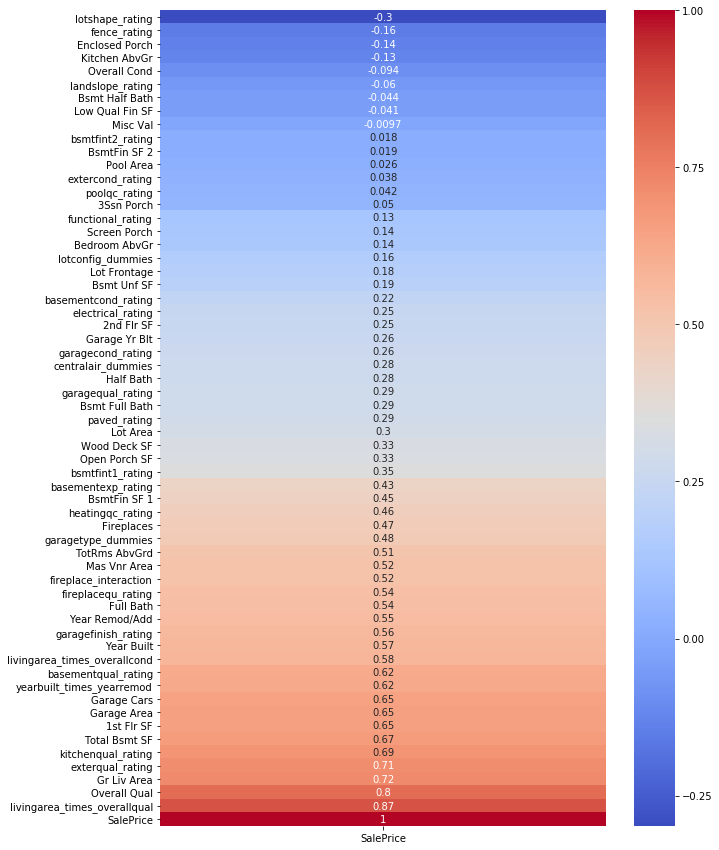

In [27]:
plt.figure(figsize=(10,15))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')

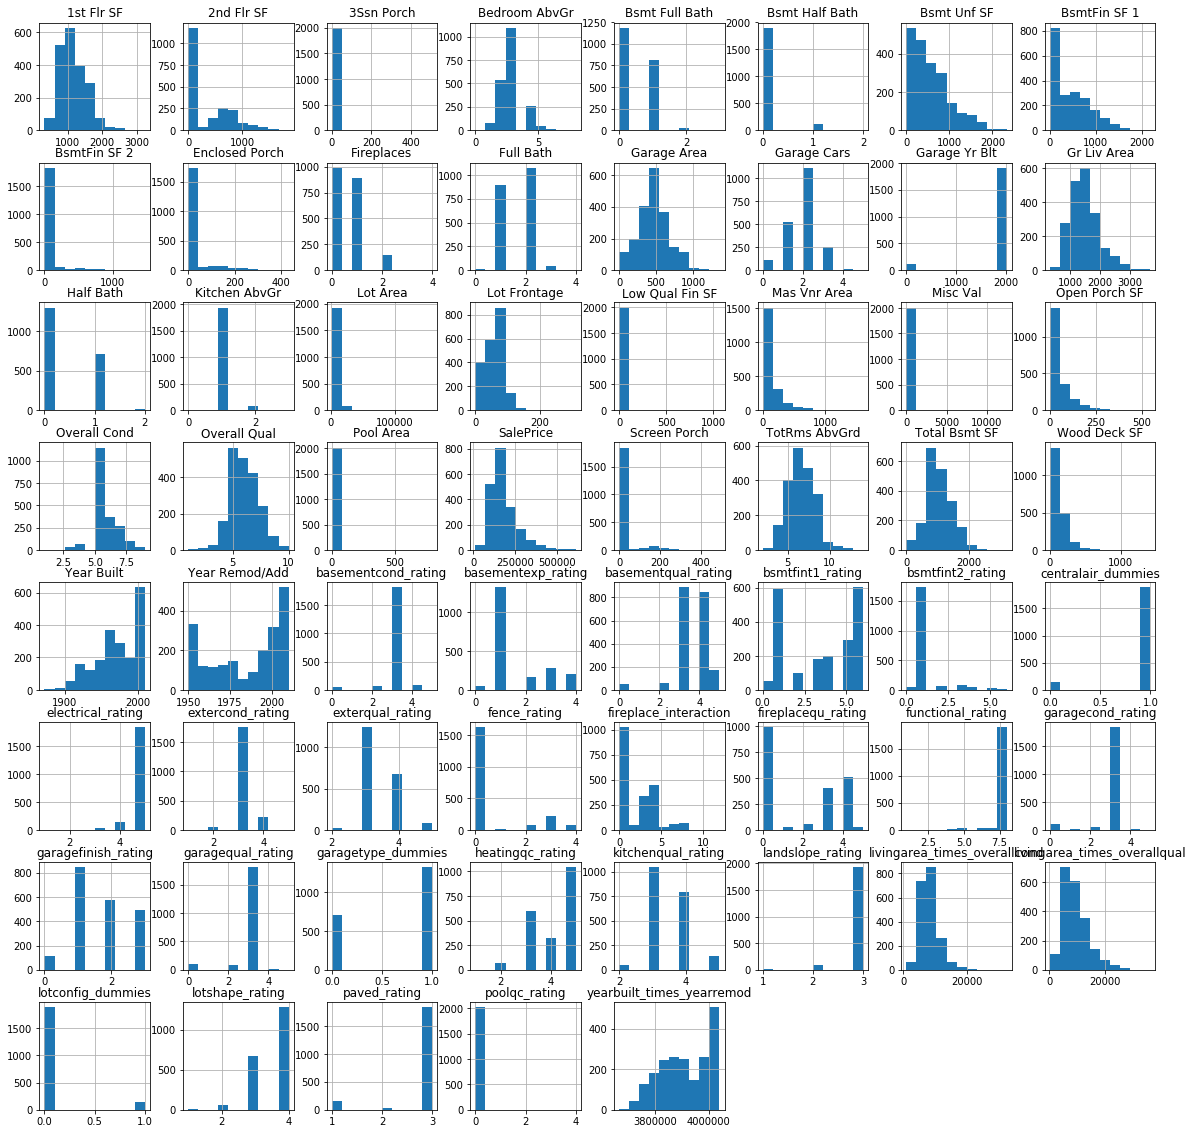

In [28]:
# Create histograms of numerical columns
df.hist(figsize=(20,20));

# Preprocessing

In [29]:
# Take all numerical columns that is not Sale Price and use it as a feature. Dummy vars will be added later

numerical_columns = df._get_numeric_data().columns
features = list((set([col for col in numerical_columns if col != 'SalePrice']) - set(basement_features) - set(garage_features)) - set(all_ratings))

X = df[features]
y = df['SalePrice']
X_kaggle = test_df[features]

In [30]:
# Create dataframes on which we will create polynomial features, from the lists created above

X_ratings = df[all_ratings]
X_kaggle_ratings = test_df[all_ratings]

X_garage = df[garage_features]
X_kaggle_garage = test_df[garage_features]

X_basement = df[basement_features]
X_kaggle_basement = test_df[basement_features]

In [31]:
# merge dataframe with dummy dataframes

X = pd.concat([X, landcontour_dummies, 
               neighborhood_dummies, cond1_dummies, 
               cond2_dummies, bldg_dummies, 
               house_dummies, roof_dummies, 
               roofmatl_dummies, exterior1_dummies, 
               exterior2_dummies, mssubclass_dummies, 
               mszoning_dummies, masvnrtype_dummies, 
               foundation_dummies, misc_dummies, 
               saletype_dummies, yearsold_dummies, 
               monthsold_dummies, street_dummies,
               utilities_dummies, heating_dummies], axis=1)
X_kaggle = pd.concat([X_kaggle, test_landcontour_dummies, 
               test_neighborhood_dummies, test_cond1_dummies, 
               test_cond2_dummies, test_bldg_dummies, 
               test_house_dummies, test_roof_dummies, 
               test_roofmatl_dummies, test_exterior1_dummies, 
               test_exterior2_dummies, test_mssubclass_dummies, 
               test_mszoning_dummies, test_masvnrtype_dummies, 
               test_foundation_dummies, test_misc_dummies,
               test_saletype_dummies, test_yearsold_dummies, 
               test_monthsold_dummies, test_street_dummies,
               test_utilities_dummies, test_heating_dummies], axis=1)

In [33]:
# Now check for columns that dont match
x_drop = [a for a in list(X.columns) if a not in list(X_kaggle.columns)]
x_kaggle_drop = [a for a in list(X_kaggle.columns) if a not in list(X.columns)]

#and drop them from each 
X.drop(labels=x_drop, inplace=True, axis=1)
X_kaggle.drop(labels=x_kaggle_drop, inplace=True, axis=1)

In [34]:
# Basement features polynomial

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_poly = poly.fit_transform(X_basement)
X_poly_basement = pd.DataFrame(data = X_poly,
                             index = X_basement.index,
                             columns = poly.get_feature_names(X_basement.columns))

In [35]:
# Kaggle set basement features polynomial

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_kaggle_poly = poly.fit_transform(X_kaggle_basement)
X_kaggle_poly_basement = pd.DataFrame(data = X_kaggle_poly,
                             index = X_kaggle_basement.index,
                             columns = poly.get_feature_names(X_kaggle_basement.columns))

In [36]:
# merge with original dataframe

X = X.merge(X_poly_basement, how = "inner", 
            left_index = True, right_index = True)

X_kaggle = X_kaggle.merge(X_kaggle_poly_basement, how = "inner", 
                          left_index = True, right_index = True)

In [37]:
# Garage features polynomial

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_poly = poly.fit_transform(X_garage)
X_poly_garage = pd.DataFrame(data = X_poly,
                             index = X_garage.index,
                             columns = poly.get_feature_names(X_garage.columns))

In [38]:
# Kaggle garage features polynomial

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_kaggle_poly = poly.fit_transform(X_kaggle_garage)
X_kaggle_poly_garage = pd.DataFrame(data = X_kaggle_poly,
                             index = X_kaggle_garage.index,
                             columns = poly.get_feature_names(X_kaggle_garage.columns))

In [39]:
# merge with original dataframe

X = X.merge(X_poly_garage, how = "inner", 
            left_index = True, right_index = True)

X_kaggle = X_kaggle.merge(X_kaggle_poly_garage, how = "inner", 
                          left_index = True, right_index = True)

In [40]:
# Rating set polynomial features

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_poly = poly.fit_transform(X_ratings)
X_poly_ratings = pd.DataFrame(data = X_poly,
                             index = X_ratings.index,
                             columns = poly.get_feature_names(X_ratings.columns))

In [41]:
# Kaggle set rating polynomial features

poly = PolynomialFeatures(degree=2,
                          interaction_only=False,
                          include_bias=False)

X_kaggle_poly = poly.fit_transform(X_kaggle_ratings)
X_kaggle_poly_ratings = pd.DataFrame(data = X_kaggle_poly,
                             index = X_kaggle_ratings.index,
                             columns = poly.get_feature_names(X_kaggle_ratings.columns))

In [42]:
# merge with original dataframe

X = X.merge(X_poly_ratings, how = "inner", 
            left_index = True, right_index = True)

X_kaggle = X_kaggle.merge(X_kaggle_poly_ratings, how = "inner", 
                          left_index = True, right_index = True)

In [43]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Modeling 

In [44]:
# Scaling

ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)
ss_kaggle = StandardScaler()
ss_kaggle.fit(X_kaggle)

X_kaggle_scaled = ss_kaggle.transform(X_kaggle)

/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nourzahlan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data wi

In [45]:
## TAKEN FROM REGULARIZATION LESSON - instantiate and fit ridge model

r_alphas = np.logspace(0, 5, 100)

ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

ridge_model = ridge_model.fit(X_train_scaled, y_train)

# Evaluation

In [ ]:
# Output cross val score, train score and test score:

print("cross-val-score:", cross_val_score(ridge_model, X_train_scaled, y_train, cv=5).mean())
print('train score:', ridge_model.score(X_train_scaled, y_train))
print('test score:', ridge_model.score(X_test_scaled, y_test))

In [49]:
# generate predictions 

pred = ridge_model.predict(X_test_scaled)

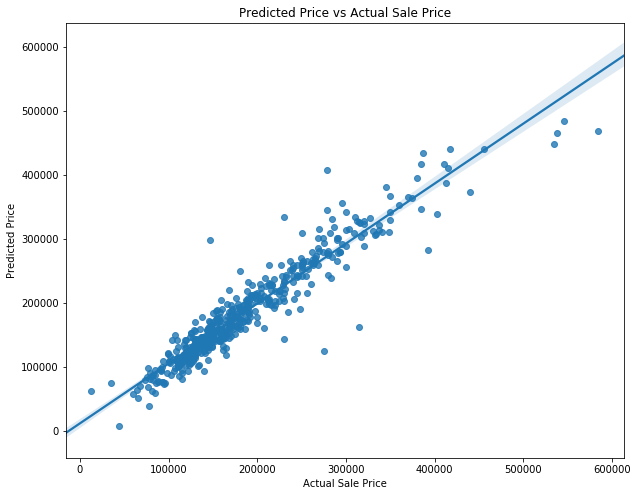

In [50]:
# plot predictions vs actual price

plt.figure(figsize=(10,8))
sns.regplot(y_test, pred)
plt.xlabel('Actual Sale Price')
plt.title('Predicted Price vs Actual Sale Price')
plt.ylabel('Predicted Price');

# Test Data 

In [51]:
# change dataframe to be able to submit predictions to kaggle

drop_features = [a for a in X_kaggle if a != 'SalePrice']
X_kaggle['SalePrice'] = ridge_model.predict(X_kaggle_scaled)
X_kaggle.drop(drop_features, inplace=True, axis=1)

# save predictions
X_kaggle.to_csv("./datasets/my_submission.csv")